# Generative Poisoning Atttack Method(Part 2)

## Generative Method

In the first part, I implemented the direct gradient method. However, according to the paper, the direct gradient method is computationally expensive. Inspired by the idea of GAN, the paper introduced another method: Generative Method. In this method, the calculation of direct gradient is not needed. A generator generates the poison image iteratively and the resnet evaluates it.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import grad

import higher

from torchvision.utils import save_image

from tqdm import tqdm_notebook as tqdm

### Step 1: Train a res-net with normal data

This is step is the same as the direct gradient method. A resnet18 is trained with normal(untainted) data. The parameters remains the same. 

In [2]:
#Define data transform
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
# Load training data
trainset_dir = './animal_data/train'
trainset = datasets.ImageFolder(trainset_dir, transform=data_transform)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 4)

# Define helper parameters
dataset_sizes = len(trainset)
class_names = trainset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is set to: ", device)

Device is set to:  cuda:0


In [3]:


resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 4)
resnet.load_state_dict(torch.load('./poinson_o_dict.pth'))
resnet = resnet.to(device)
# Loading testset
test_data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_folder_path = './animal_data/test'
test_dataset = datasets.ImageFolder(test_folder_path, transform=test_data_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = True, num_workers = 4)

running_corrects = 0

#test the model
for images, labels in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = resnet(images)
    _, pred = torch.max(outputs, 1)
    
    running_corrects += torch.sum(pred == labels)
    
print("Tested {} images".format(len(test_dataset)))
print("{} images are labeled correctly".format(running_corrects))
print("Model accuarycy is: {:.2f}".format(running_corrects.double()/len(test_dataset)))

Tested 71 images
60 images are labeled correctly
Model accuarycy is: 0.85


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

### Step 2: Select a target image and a poison image.

Same as the direct gradient method, I randomly select 2 images from the training set and use them as target image and poison image. 

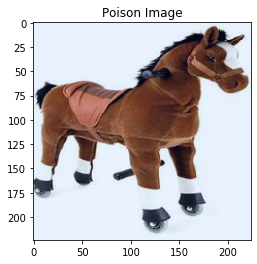

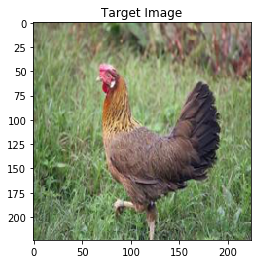

In [5]:


def single_imshow(image, title):
    #Takes in a numpy
    img = image[0].transpose((1,2,0))
    
    img = (img - np.min(img))/(np.max(img)-np.min(img))
    plt.imshow(img)
    plt.title(title)
    plt.show()
# Select two images from the training set and use one of them as poison image and one as target image
poison_dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True,num_workers=4)
target_dataloader = torch.utils.data.DataLoader(trainset, batch_size = 1, shuffle=True, num_workers=4)

poison_image, poison_label = next(iter(poison_dataloader))
target_image, target_label = next(iter(target_dataloader))

poison_image, poison_label = poison_image.to(device), poison_label.to(device)
target_image, target_label = target_image.to(device), target_label.to(device)

poison_image.requires_grad = True
single_imshow(poison_image.detach().cpu().numpy(), "Poison Image")
single_imshow(target_image.detach().cpu().numpy(), "Target Image")

In [6]:


outputs = resnet(target_image)
_, target_pred = torch.max(outputs, 1)
print("The groud truth is:", class_names[target_label])
print("The prediction is:", class_names[target_pred])
print("Loss: ", str(criterion(outputs, target_label).item()))

The groud truth is: chickens
The prediction is: chickens
Loss:  0.015506744384765625


### Step 3: Define a generator.

In this step, I define the generator that generates the poison image. In the paper, the author implemented this method with MNIST dataset and used an auto-encoder based neural network as the generator. The structure of the generator they constructed is 784-200-200-784. I am dealing with more complicated images, so I choose to use convolutional layers in the generator. The idea is similar. My generator consists of four convolutional layers with batch-norm and relu layers in between. This structure works for me, but it is rather arbitrary. 

In [7]:
nc = 3
generator = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nc, 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
    
            nn.ConvTranspose2d( 4, 4, 4, 1, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
    
            nn.ConvTranspose2d( 4, 4, 4, 1, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),

            nn.ConvTranspose2d( 4, nc, 4, 1, 1, bias=False),
            nn.Tanh()

        )
generator = generator.to(device)


### Step 4: Update the generator's parameters

In this step, the loss of the target image fed into the poisoned resnet(loss_p_i) is calculated and feed into the generator to update its paramters. Notice that the goal is to maximize loss_p_i, I use -loss_p_i as the actual loss function. Detailed step is in comments 

In [8]:
# Define parameters:
max_iter = 3000
criterion = nn.CrossEntropyLoss()
optimizer_ft_d = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
optimizer_ft_g = optim.SGD(generator.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

# Change the label to an inccorect one
if poison_label[0] == 0:
    poison_label[0] = 1
else:
    poison_label[0] = 0


for i in tqdm(range(max_iter)):
    
    # Step 0: Reset resnet parameters
    resnet.load_state_dict(torch.load('./poinson_o_dict.pth'))
    
    # Step 1: Calculate p_loss, p_loss is the loss of poison image fed into original model
    p_outputs = resnet(generator(poison_image))
    p_loss = criterion(p_outputs, poison_label)
    p_loss.backward(retain_graph = True)
    
    # Step 2: Update model parameters to obtain a poison model. 
    optimizer_ft_d.step()
    
    
    # Step 3: Calculate the loss of target image fed into poisoned model(loss_p_i)
    o_outputs = resnet(target_image)
    loss_p_i = -criterion(o_outputs, target_label)
    loss_p_i.backward()
    
    # Step 4: update generator parameter. Notice the negative sign. I am trying to maximize loss_p_i.
    optimizer_ft_g.step()
    
    



            



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### Step 5: Test the poison image

At this point, the generator is trained to generate an image that maximizes loss_p_i. To generate a poison image, simply run: generator(input)

In [9]:
poison_save = generator(poison_image)

Inject poison image into training set.

In [10]:
poison_img_path = './animal_data/train/' + class_names[poison_label[0]] +'/poison.jpeg'
save_image(poison_save[0], poison_img_path)
print("Poison image is injected into: ", poison_img_path)

Poison image is injected into:  ./animal_data/train/butterflies/poison.jpeg


Retrain the model with poisoned training set.

In [12]:
#Define data transform
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
# Load training data
trainset_dir = './animal_data/train'
trainset = datasets.ImageFolder(trainset_dir, transform=data_transform)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size = 8, shuffle = True, num_workers = 4)

dataset_sizes = len(trainset)
class_names = trainset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [13]:

resnet = models.resnet18(pretrained = False)
resnet_in_feature = resnet.fc.in_features
resnet.fc = nn.Linear(resnet_in_feature, len(class_names))
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

epoch_num = 15
for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in trainset_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer_ft.zero_grad()
        
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes
    epoch_acc = running_corrects.double() / dataset_sizes
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch, epoch_loss, epoch_acc))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


0 Loss: 1.1444 Acc: 0.5016
1 Loss: 0.9155 Acc: 0.6222
2 Loss: 0.7810 Acc: 0.6899
3 Loss: 0.6676 Acc: 0.7430
4 Loss: 0.6163 Acc: 0.7712
5 Loss: 0.5354 Acc: 0.7987
6 Loss: 0.4627 Acc: 0.8266
7 Loss: 0.4265 Acc: 0.8407
8 Loss: 0.3675 Acc: 0.8674
9 Loss: 0.3253 Acc: 0.8849
10 Loss: 0.2950 Acc: 0.8946
11 Loss: 0.2613 Acc: 0.9113
12 Loss: 0.2536 Acc: 0.9084
13 Loss: 0.2169 Acc: 0.9239
14 Loss: 0.2075 Acc: 0.9242



After training the model with poisoned dataset, I test the model on the target image. If I see a significant increase on the loss and the target image is miss classified. The attack is successful

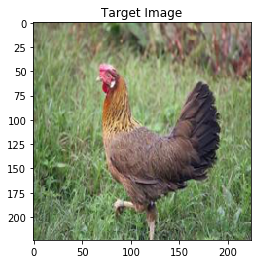

The groud truth is:  chickens
The prediction is:  horses
Loss:  1.0491650104522705
Target image is miss classified, attack is successful.


In [14]:
single_imshow(target_image.detach().cpu().numpy(), "Target Image")
t_outputs = resnet(target_image)
_, t_pred = torch.max(t_outputs, 1)
print("The groud truth is: ", class_names[target_label])
print("The prediction is: ", class_names[t_pred])
print("Loss: ", str(criterion(t_outputs, target_label).item()))
if t_pred != target_label:
    print("Target image is miss classified, attack is successful.")

## Conclusion

This project simply demenstrates my interest and understanding of this poisoning attack method. For more information please refer to the original paper: "Generative Poisoning Attack Method Against Neural Networks" by Chaofei Yang, Qing Wu, Hai Li, and Yiran Chen.
https://arxiv.org/abs/1703.01340

I made a modification inorder to demenstrate the result of this algrithm. I am only poisoning one target image with one poisoning image whereas the original algrithm is designed to poison the entire model with one poison image. Notice it is also possible to make this attack targeted. This means that with some modification, this algrithm can generates a poison image that cause the target image to be miss-classified to a targeted label. 